## Acknowledgements

All of this code was written by Jeremy Howard and the FastAI Team. I modified it slightly to include my own print statements, comments and additional helper functions based on Jeremy's code. This is the source for the original code [Scaling Up: Road to the Top, Part 3](https://www.kaggle.com/code/jhoward/scaling-up-road-to-the-top-part-3), [Multi-Target: Road to the Top, Part 4](https://www.kaggle.com/code/jhoward/multi-target-road-to-the-top-part-4) and [Collaborative Filtering Deep Dive](https://www.kaggle.com/code/jhoward/collaborative-filtering-deep-dive/notebook).

## Summary

In this lesson, Jeremy explains Collaborative Filtering and how its application in *recommendation systems* and continues the discussion of how to iterate solutions for the [Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification) challenge.

The section on *cross-entropy loss* was difficult for me but rewatching Jeremy's discussion of the math and writing the code helped me understand the math.

## Jeremy Howard's Advice

- The stuff that happens in the first layer of the model and the last layer including the loss function that sits between the last layer and the loss are very important in deep learning

## Terminology

**Ensemble** - model which is itself the result of combining a number of other models. The simplest way to do ensembling is to take the average of the predictions of each model.

**Gradient Accumulation** - rather than updating the model weights after ever batch based on that batch's gradients, instead keep *accumulating* (adding) the gradients for a few batches, and thenupdate the model weights with those accumulated gradients.

**Collaborative Filtering (Recommendation Systems)** - look at what products the current user has used or liked, find other users that hae used or liked similar products and then recommend other products that those users have used or liked.

**Latent Factors** - Find what features matter. In the movie case study, the latent factors are what things matter most to a person when they choose to watch a particular movie.

**Embeddings** - special layer in pytorch that indexes into a vector using an integer, and has its derivative calculated in such a way that it is identical to what would have been if it had done a matrix multiplication with a one-hot-encoded vector.

**Weight Decay** - weight decay or `L2 Regularization` is adding to your loss function the sum of all the weights squared. When computing the gradients, this forces the weights to be as small as possibl. This helps prevent overfitting because the larger the coefficients are, the sharper the canyons appear in the loss function

## Cross Entropy Loss

Cross Entropy Loss is confusing to understand just by looking at the math equations in the [pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Here I will try my best to explain how it works.

Like the other loss functions Jeremy has talked about cross entropy loss is a loss function we are using to determine how good our model is. In order to compute the cross entropy loss we do the following steps:

1. Compute the SoftMax
2. Compute the Cross Entropy Loss using the SoftMax

### SoftMax

In the FastAI Lesson 7 video, Jeremy uses an example with five different image classes: **cat**, **dog**, **plane**, **fish**, **building** with the goal of predicting whether some image is one of those categories. I will be using the same example.

Given some random weights and after doing some work, the image model will output 5 `output` values corresponding to the image classes from above:

**cat** = -4.89
**dog** = 2.60
**plane** = 0.59
**fish** = -2.07
**building** = -4.57

To use these values in cross entropy loss, they need to be converted to probabilities. **Softmax** is a function that converts numbers to probabilities using the following equation:
$$\frac{e^{z_{i}}}{\sum_{j=1}^{K}e^{z_{j}}}$$

In the equation, **K** represents the number of categories, **zj** and **zi**represents the output value for the corresponding category. Adding up the softmax results for each category, we get a total of **1.0** because the sum of all probabilities in an experiment is **1.0**.

### Cross Entropy

The cross entropy function is defined as the following:
$$-\sum_{i=1}^{M}y_{i}\log{p(y_{i})} + (1 - y_{i})\log(1 - p(y_{i}))$$

In the equation, **M** represents the number of categories and **yi** represents the category.

Using the probabilities calculated by the softmax function we can simplify the cross entropy function to the following:
-sum(**actual target value** * **log(prediction probability)**).

Cross Entropy is finding the probability of the target class where the actual target value is 1 and then taking the log of the probability - where 1 is the correct value and 0 is the incorrect value.

### Binary Cross Entropy

$$-\sum_{i=1}^{N}y_{i}log(p(y_{i}) + (1 - y_{i})log(1 - p(y_{i}))$$

In the equation, the **sum** represents the total over the number of trials, **yi** represents the label.

## Load Data and Libraries

In [1]:
# import libraries and files

# required libraries + packages for any ml/data science project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# fastai library contains all the packages above and wraps them in the fastai library
!pip install -Uqq fastai

# install PyTorch Image Models (TIMM)
!pip install timm==0.6.13

# kaggle API package install
!pip install kaggle

!pip install pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 897.6 kB/s eta 0:00:00


In [2]:
from fastai.imports import *
import os
from pathlib import Path
import zipfile

'''Function for loading kaggle datasets locally or on kaggle
Returns a local path to data files
- input: Kaggle API Login Credentials, Kaggle Contest Name '''
def loadData(creds, dataFile):
    # variable to check whether we're running on kaggle website or not
    iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

    # path for kaggle API credentials
    cred_path = Path('~/.kaggle/kaggle.json').expanduser()

    if not cred_path.exists():
        cred_path.parent.mkdir(exist_ok=True)
        cred_path.write_text(creds)
        cred_path.chmod(0o600)

    # Download data from Kaggle to path and extract files at path location

    # local machine
    path = Path(dataFile)
    if not iskaggle and not path.exists():
        import kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

    # kaggle
    if iskaggle:
        fileName = '../input/' + dataFile
        path = fileName

    return path

In [3]:
creds = ''
dataFile = 'paddy-disease-classification'
path = loadData(creds, dataFile)

100%|██████████| 1.02G/1.02G [00:14<00:00, 76.2MB/s]


In [4]:
# check data files
! ls {path}

sample_submission.csv  test_images  train.csv  train_images


In [5]:
# set up default settings
import warnings, logging, torch
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [6]:
# load data files
from fastai.vision.all import *
set_seed(42)

df = pd.read_csv(path/'train.csv')
test_files = get_image_files(path/'test_images').sorted()

## Paddy Doctor

### Part 3

#### Memory + Gradient Accumulation

- Goal: Train an ensemble of large models with large inputs
- The bottleneck for training such models is GPU memory
- Kaggle GPUS have 16280 MiB of available memory

In [7]:
# file count
df.label.value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [8]:
# - bacterial panicle blight has the least files so use that for testing models and images
trn_path = path/'train_images'/'bacterial_panicle_blight'

In [9]:
# - finetune argument to specify whether to run fine_tune() or the fit_one_cycyle() -> fit_one_cycle()
# is faster since it doesn't do an intiial fine-tuning of the head
# - In the finetune function the TTA predictions on the test set are calculated and returned
# - accum argument is used for calculating gradient accumulation
def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=12):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        return learn.tta(dl=dls.test_dl(test_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

#### Gradient Accumulation

- fastai has a GradientAccumulation parameter that you pass to define how many batches of gradients are accumulated
- After adding up all the gradients over accum batches, we need to divide the batch size by that number
- the resulting loop is nearly identical to using the original batch size but the amount of memory used is the same as using a batch size `accum` times smaller

In [10]:
# single epoch training loop without gradient accumulation

# for x, y in dl:
#   calc_loss(coeffs, x, y).backward()
#   coeffs.data.sub_(coeffs.grad * lr)
#   coeffs.grad.zero_()

In [11]:
# gradient accumulation added (assuming a target effective batch size of 64)

# # number of items seen since last weight update
# count = 0
# for x,y in dl:
#  # update count based on this minibatch size
#     count += len(x)
#     calc_loss(coeffs, x, y).backward()
#  # count is greater than accumulation target, so do weight update
#     if count > 64:
#         coeffs.data.sub_(coeffs.grad * lr)
#         coeffs.grad.zero_()
# # reset count
#         count = 0

#### Memory Consumption Analysis

In [12]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [13]:
# accum = 1
train('convnext_small_in22k', 128, epochs=1, accum=1, finetune=False)
report_gpu()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:08


GPU:0
process       4883 uses     3260.000 MB GPU memory


In [14]:
# accum = 2
train('convnext_small_in22k', 128, epochs=1, accum=2, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:03


GPU:0
process       4883 uses     2200.000 MB GPU memory


In [15]:
# accum = 4
train('convnext_small_in22k', 128, epochs=1, accum=4, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:05


GPU:0
process       4883 uses     1664.000 MB GPU memory


In [16]:
# convnext large
train('convnext_large_in22k', 224, epochs=1, accum=2, finetune=False)
report_gpu()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:07


GPU:0
process       4883 uses    10082.000 MB GPU memory


In [17]:
train('convnext_large_in22k', (320,240), epochs=1, accum=2, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:08


GPU:0
process       4883 uses    13422.000 MB GPU memory


In [18]:
# vit_large - close to going over 16280MiB in Kaggle
train('vit_large_patch16_224', 224, epochs=1, accum=2, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:09


GPU:0
process       4883 uses    14360.000 MB GPU memory


In [19]:
# swinv2
train('swinv2_large_window12_192_22k', 192, epochs=1, accum=2, finetune=False)
report_gpu()



Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:09


GPU:0
process       4883 uses    12508.000 MB GPU memory


In [20]:
# swin
train('swin_large_patch4_window7_224', 224, epochs=1, accum=2, finetune=False)
report_gpu()

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:07


GPU:0
process       4883 uses    10924.000 MB GPU memory


#### Experimenting with different models

In [ ]:
# image sizes
res = 640, 480

# different models
models = {
    'convnext_large_in22k': {
        (Resize(res), (320,224)),
    }, 'vit_large_patch16_224': {
        (Resize(480, method='squish'), 224),
        (Resize(res), 224),
    }, 'swinv2_large_window12_192_22k': {
        (Resize(480, method='squish'), 192),
        (Resize(res), 192),
    }, 'swin_large_patch4_window7_224': {
        (Resize(res), 224),
    }
}

In [ ]:
# switch to all training images
trn_path = path/'train_images'

In [ ]:
# - each model is using different training and validation sets so results are not comparable
# - append each set of TTA predictions on the test set into the tta_res list
tta_res = []

for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        tta_res.append(train(arch, size, item=item, accum=2)) #, epochs=1))
        gc.collect()
        torch.cuda.empty_cache()

--- convnext_large_in22k
(320, 224)
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,0.858722,0.499460,0.165786,03:24


epoch,train_loss,valid_loss,error_rate,time
0,0.385716,0.208010,0.061509,04:33
1,0.310007,0.212928,0.061028,04:31
2,0.351554,0.228603,0.066314,04:28
3,0.221846,0.182669,0.054301,04:27
4,0.153551,0.156956,0.045171,04:29
5,0.149726,0.149253,0.037001,04:27
6,0.090776,0.127437,0.031235,04:26
7,0.081606,0.115022,0.028832,04:30
8,0.044530,0.108681,0.023546,04:26
9,0.035370,0.105452,0.023546,04:25


--- vit_large_patch16_224
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,1.004288,0.582304,0.187890,03:54


epoch,train_loss,valid_loss,error_rate,time
0,0.384640,0.259779,0.074003,05:11
1,0.352266,0.273039,0.075925,05:14
2,0.378463,0.300954,0.073522,05:10
3,0.246590,0.394313,0.087458,05:04
4,0.241524,0.235776,0.061509,05:04
5,0.139398,0.231180,0.061989,05:04
6,0.114390,0.198267,0.042287,05:04
7,0.079242,0.174894,0.035079,05:13
8,0.040460,0.150516,0.028352,05:14
9,0.035262,0.140247,0.029313,05:09


--- vit_large_patch16_224
224
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,0.945174,0.587339,0.188852,03:56


epoch,train_loss,valid_loss,error_rate,time
0,0.431525,0.264968,0.085536,05:07
1,0.373674,0.285950,0.083133,05:07
2,0.294009,0.283589,0.075925,05:06
3,0.283224,0.297093,0.083133,05:06
4,0.196644,0.185746,0.048054,05:09
5,0.153443,0.165554,0.037963,05:15
6,0.122116,0.162079,0.039885,05:22
7,0.105744,0.148939,0.036040,05:13
8,0.073754,0.101312,0.024988,05:07
9,0.038434,0.106780,0.021624,05:04


--- swinv2_large_window12_192_22k
192
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,0.941143,0.501398,0.165786,03:40


epoch,train_loss,valid_loss,error_rate,time
0,0.438842,0.208749,0.061028,04:25
1,0.355431,0.220552,0.061509,04:33
2,0.349027,0.397794,0.120135,04:35
3,0.293179,0.189101,0.053820,04:41
4,0.206543,0.163805,0.046612,04:40
5,0.186177,0.128186,0.035560,04:41
6,0.113470,0.114702,0.025949,04:24
7,0.112366,0.092310,0.024988,04:24
8,0.074616,0.091132,0.021144,04:25
9,0.042644,0.079768,0.020663,04:24


--- swinv2_large_window12_192_22k
192
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,0.965668,0.443010,0.141278,03:42


epoch,train_loss,valid_loss,error_rate,time
0,0.448268,0.263037,0.083133,04:27
1,0.355133,0.252433,0.081211,04:26
2,0.333021,0.213186,0.064873,04:28
3,0.278992,0.219155,0.066314,04:26
4,0.204435,0.168250,0.053820,04:26
5,0.180749,0.170310,0.045171,04:25
6,0.143278,0.142150,0.032196,04:25
7,0.100807,0.110142,0.026910,04:27
8,0.051518,0.101470,0.023546,04:24
9,0.039993,0.097524,0.025469,04:25


--- swin_large_patch4_window7_224
224
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,0.966472,0.521585,0.164344,03:16


epoch,train_loss,valid_loss,error_rate,time
0,0.409947,0.254923,0.073522,03:56
1,0.363681,0.227124,0.070639,03:56
2,0.361192,0.202026,0.065834,03:56
3,0.276248,0.296600,0.083614,03:56


#### Ensembling all the models

In [ ]:
# save all results
save_pickle('tta_res.pkl', tta_res)

In [ ]:
# - Learner.tta returns predictions and targets for each row

# get predictions
tta_prs = first(zip(*tta_res))

In [ ]:
# - Jeremy's experiments and research figured out that vit was a better than all the other models
# - Based on the experiments, vit has double the weight in the ensemble
# - vit double weight -> add vit results to the ensemble (or compute a weighted average)
tta_prs += tta_prs[1:3]

In [ ]:
# - ensemble: a model which is itself the result of combining a number of other models
# - simplest way of ensembling is to take the average of the predictions of each model
avg_pr = torch.stack(tta_prs).mean(0)
print(f"avg prediction shape: {avg_pr.shape}")
print(f"avg prediction rank: {len(avg_pr.shape)}")

#### Submission

In [ ]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [ ]:
idxs = avg_pr.argmax(dim=1)
vocab = np.array(dls.vocab)
sample_sub = pd.read_csv(path/'sample_submission.csv')
sample_sub['label'] = vocab[idxs]
sample_sub.to_csv('part3_subm.csv', index=False)
!head part3_subm.csv

### Part 4

- predict what disease the rice paddy has AND what kind of rice is shown

In [21]:
# load data files
from fastai.vision.all import *
from fastcore.parallel import *
set_seed(42)

trn_path = path/'train_images'
df = pd.read_csv(path/'train.csv', index_col='image_id')

In [22]:
# data summary
df.head()

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


In [23]:
# - get rice variety from rice image data
df.loc['100330.jpg', 'variety']

'ADT45'

In [24]:
# rice variety helper function
def get_variety(p):
  return df.loc[p.name, 'variety']

In [25]:
# Dataloader + Datablock setup
dls = DataBlock(
    # - create an image(contents of file), 2 categorical variables(disease and variety)
    blocks=(ImageBlock,CategoryBlock,CategoryBlock),
    # - 1 input(the image), 2 outputs(disease category, variety category)
    n_inp=1,
    # - get list of inputs (image files)
    get_items=get_image_files,
    # - create the outputs for each image file (parent image label, variety(from variety function))
    get_y = [parent_label,get_variety],
    # - split data into 80% training, 20% validation
    splitter=RandomSplitter(0.2, seed=42),
    # - batch transforms
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path)

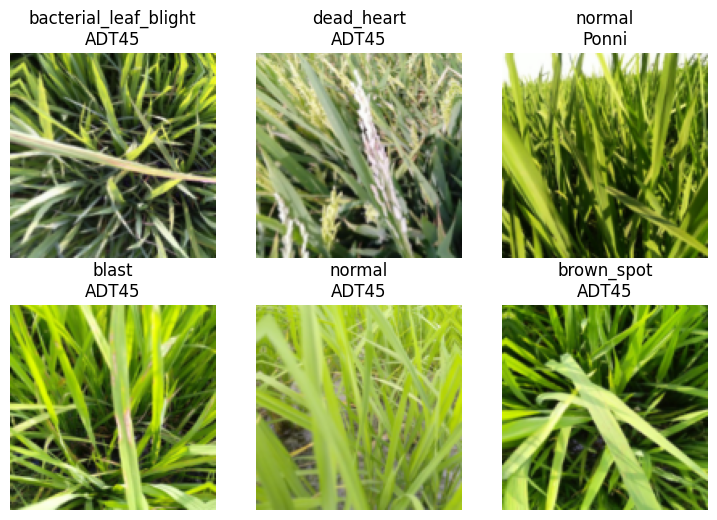

In [26]:
# batch analysis
dls.show_batch(max_n=6)

#### Disease Model

- metric and loss function will take three inputs:
1. model outputs(metric and loss function inputs)
2. two targets (disease and variety)

##### Metric + Loss Functions

In [27]:
# metric and loss functions

# metric function
def disease_err(inp,disease,variety):
  return error_rate(inp,disease)

# loss function - cross entropy
def disease_loss(inp,disease,variety):
   return F.cross_entropy(inp,disease)

In [28]:
# learner setup
arch = 'convnext_small_in22k'
learn = vision_learner(dls, arch, loss_func=disease_loss, metrics=disease_err, n_out=10).to_fp16()
# learning rate
lr = 0.01

In [29]:
# train and fine tune model
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,disease_err,time
0,1.295816,0.941801,0.281115,01:24


epoch,train_loss,valid_loss,disease_err,time
0,0.641056,0.494316,0.152331,01:23
1,0.466232,0.332578,0.095147,01:25
2,0.304405,0.187158,0.059587,01:24
3,0.170902,0.167094,0.048054,01:24
4,0.126892,0.147188,0.038924,01:24


#### Multi-Target Model

In [30]:
# - to predict probability of disease and variety we need model to output a tensor of length 20
# 10 possible diseases, 10 possible varities -> n_out=20 sets this up
learn = vision_learner(dls, arch, n_out=20).to_fp16()

##### Metric + Loss Functions

In [31]:
# loss functions
# - input tensor is length 20 but need to use first 10 values for disease

# disease loss
def disease_loss(inp, disease, variety):
  return F.cross_entropy(inp[:,:10],disease)

# variety loss
def variety_loss(inp,disease,variety):
  return F.cross_entropy(inp[:,10:],variety)

# total loss
def combine_loss(inp,disease,variety):
  return disease_loss(inp,disease,variety) + variety_loss(inp,disease,variety)

In [32]:
# error rate functions

# disease metric
def disease_err(inp,disease,variety):
  return error_rate(inp[:,:10],disease)

# variety metric
def variety_err(inp,disease,variety):
  return error_rate(inp[:,10:],variety)

# all error rate
err_metrics = (disease_err, variety_err)

In [33]:
# all metrics
all_metrics = err_metrics + (disease_loss,variety_loss)

##### Train Model

In [34]:
# train learner and finetune
learn = vision_learner(dls, arch, loss_func=combine_loss, metrics=all_metrics, n_out=20).to_fp16()
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.307458,1.334855,0.288323,0.133109,0.893397,0.441458,01:19


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.010617,0.681740,0.154253,0.062951,0.472450,0.209290,01:25
1,0.763498,0.449330,0.101874,0.046132,0.312340,0.136990,01:33
2,0.470782,0.310100,0.066314,0.030274,0.220500,0.089600,01:28
3,0.289418,0.217040,0.044210,0.018260,0.155922,0.061118,01:29
4,0.204842,0.204496,0.042287,0.017299,0.155690,0.048806,01:26


## Collaborative Filtering Deep Dive

### Load Data + Set Up

In [35]:
# set up some stuff
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

In [36]:
# movie dataset
path = untar_data(URLs.ML_100k)

In [37]:
# load data files
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user','movie','rating','timestamp'])

### Exploratory Data Analysis

In [38]:
# exploratory analysis
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Experiments

In [39]:
# - very science fiction = 0.98
# - very action = 0.9
# - very not as old = -0.9
last_skywalker = np.array([0.98,0.9,-0.9])

In [40]:
# user who likes modern sci-fi movies
# - very science fiction = 0.9
# - very action = 0.8
# - very not as old = -0.6
user1 = np.array([0.9,0.8,-0.6])

In [41]:
# match between lastskywalker and user1
(user1 * last_skywalker).sum()

2.1420000000000003

In [42]:
# - very science fiction = -0.99
# - very action = -0.3
# - very not as old = 0.8
casablanca = np.array([-0.99,-0.3,0.8])

# match between casablanca and user
(user1 * casablanca).sum()

-1.611

### Learning Latent Factors

- gradient descent can be used to learn the latent factors

1. randomly initialize some parameters. parameters will be a set of latent factors for each user and movie
2. calculate predictions. take dot product of each movie and user. High number represents match, low number represents mismatch
3. calculate loss. mean square error is good for representing accuracy of a prediction

In [43]:
# movie data
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [44]:
# movie + rating data
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [45]:
# Dataloaders
# - first column is for the user
# - second column is for the item (movies)
# - third column is for the rating
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [46]:
# represent movie and user late factor table as matrices
# - result = index of the move in movie latent factor matrix * index of the user in user late factor matrix
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

### Embeddings

In [47]:
# convert index lookup to matrix product
# - replace indices with one-hot encoded vectors

# multiply a vector by a one hot-encoded vector representing index 3
one_hot_3 = one_hot(3, n_users).float()
print(f"dot product of user factors and one-hot encoded three: {user_factors.t() @ one_hot_3}")
print(f"vector at index 3 in user factor matrix: {user_factors[3]}")

dot product of user factors and one-hot encoded three: tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])
vector at index 3 in user factor matrix: tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])


### Collaborative Filtering From Scratch

In [48]:
# Dot Product Class
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [49]:
#  - input of the model is a tensor of shape batch_size x 2
# - first column x[:0] contains user IDS
# - second column x[:1] contains movie IDS
# - embedding layers represent matrices of user and movie latent factors
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [50]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [51]:
# train model
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:08
1,1.093331,1.109981,00:07
2,0.958258,0.990199,00:08
3,0.814234,0.894916,00:08
4,0.780714,0.882022,00:08


In [52]:
# force predictions to be between 0 and 5 (match the reviews)
# - good to have range go a bit over 5
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [53]:
# train model
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:08
1,0.878134,0.918898,00:08
2,0.675850,0.875467,00:09
3,0.483372,0.877939,00:08
4,0.378927,0.881887,00:08


### Dot Product + Bias

- some users are more positive or negative in their recommendations than others, and some movies are better or worse than others
- the dot product representation from above does not encode this information

In [54]:
# add biases
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [55]:
# train model
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.938634,0.952516,00:09
1,0.846664,0.865633,00:09
2,0.608090,0.865127,00:09
3,0.413482,0.887318,00:08
4,0.286971,0.894876,00:09


### Weight Decay

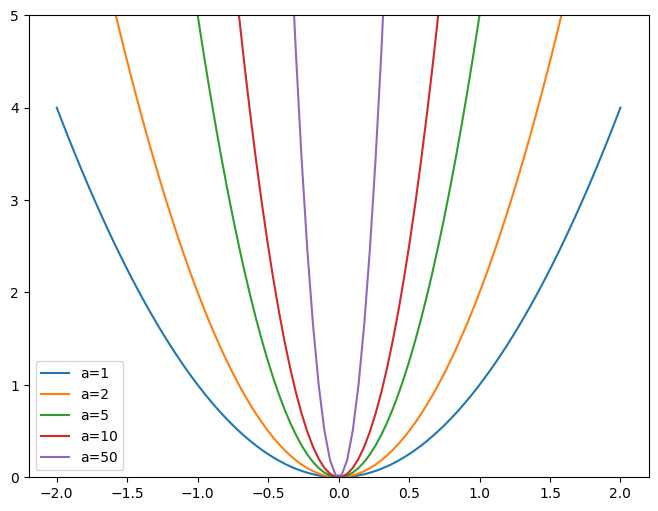

In [56]:
# Weight decay with parabola
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50]
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend()

In [57]:
# train movie model with weight decay parameter
# - weight decay is parameter that controls the sum of squares added to loss function
# - in practice it is very inefficient (and potentially numerically unstable) to compute large sums and add them to the loss
# - fastai sets weight decay with weight decay parameter
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.932776,0.961672,00:09
1,0.888625,0.882614,00:09
2,0.771066,0.832743,00:09
3,0.599807,0.822374,00:09
4,0.504981,0.822528,00:09


### Embeddings from Scratch

In [58]:
# Embedding Module From Scratch
class T(Module):
  def __init__(self):
    self.a = nn.Linear(1, 3, bias=False)
    # self.a = nn.Parameter(torch.ones(3))

t = T()
L(t.parameters())

# check type of t
print(f"T type: {type(t.a.weight)}")


T type: <class 'torch.nn.parameter.Parameter'>


In [59]:
# create tensor with random initialization
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [60]:
# DotProduct with bias (and without embedding)
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [61]:
# train model
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.929254,0.953444,00:09
1,0.865246,0.878304,00:10
2,0.720294,0.838921,00:10
3,0.582796,0.829129,00:09
4,0.474043,0.829031,00:09


### Interpreting Embeddings + Biases

In [62]:
# - biases are easiest to interpret
# - movies with the lowest values in bias vector
# - for each of these movies, even when a user is matched to its latent factors, they still don't generally like it
# - does not tell us whether a movie is of a kind that people tend to enjoy watching but that people tend not to like
# watching it even if it is of a kind they would otherwise enjoy
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Amityville 3-D (1983)',
 'Beautician and the Beast, The (1997)']

In [63]:
# movies with high bias
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

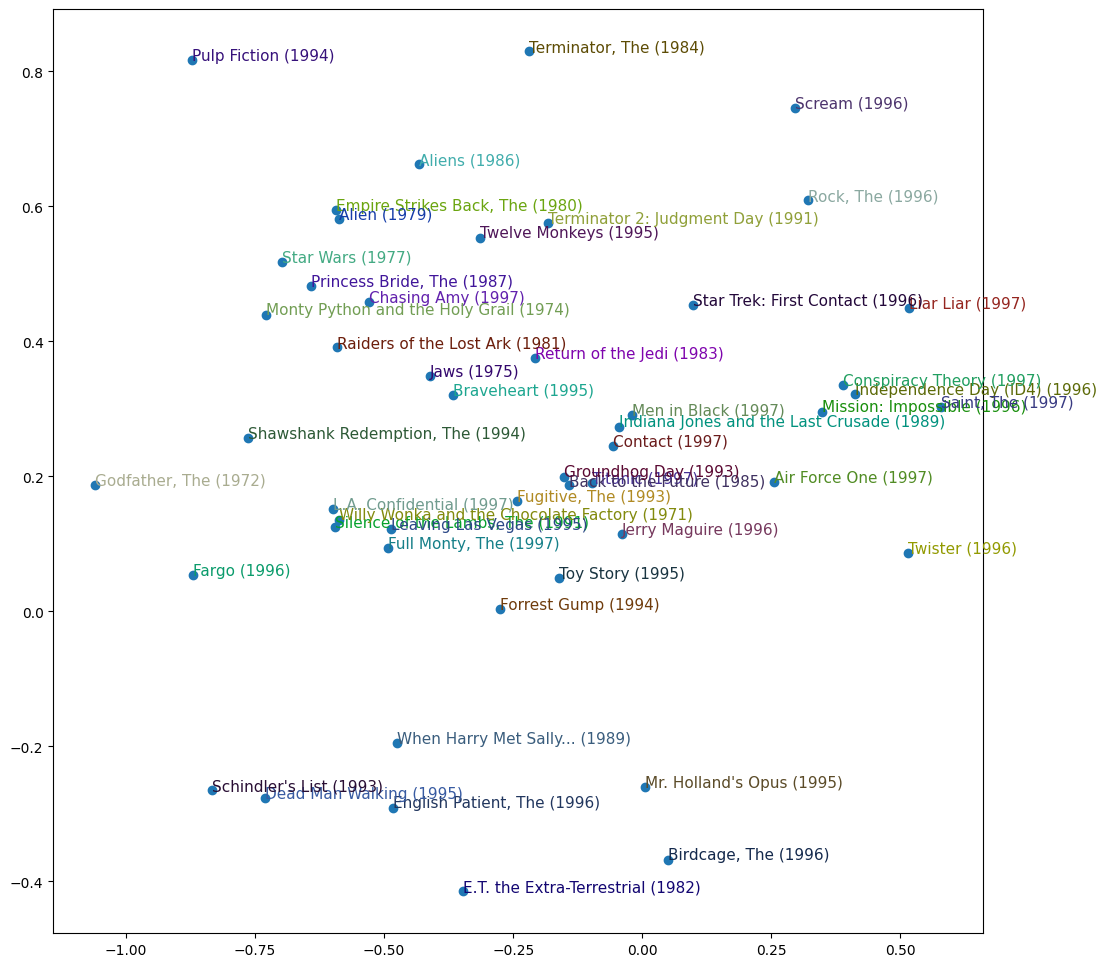

In [64]:
# PCA analysis of the two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### fastai collaborative filtering

In [65]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.939463,0.954959,00:10
1,0.841215,0.876151,00:09
2,0.724404,0.832099,00:09
3,0.597228,0.816953,00:08
4,0.481373,0.817286,00:09


In [66]:
# print layer names of model
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [67]:
# high bias movies
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)']

### Embedding Distance

In [68]:
# - distance between two movie embeddings can define two movies that are nearly identical 
# because users that would like them would be nearly exactly the same

# find movie most similar to Silence of the Lambs
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Before the Rain (Pred dozhdot) (1994)'

### Deep Learning + Collaborative Filtering

In [69]:
# fastai has a function that returns the recommended size for embeddings matrices for your data based on a heuristic FastAI found
# that works well in practice
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [70]:
# Deep Learning Collaborative Filtering Class
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range

    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [71]:
# create model and train it
model = CollabNN(*embs)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.943857,0.951898,00:10
1,0.914082,0.898525,00:10
2,0.848892,0.884356,00:10
3,0.814803,0.875278,00:10
4,0.761398,0.878594,00:09


In [72]:
# model with hidden layers of 100 and 50
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.003178,0.998673,00:11
1,0.877362,0.934763,00:11
2,0.887651,0.898290,00:11
3,0.815599,0.865441,00:12
4,0.788975,0.864559,00:11


## Resources

1. [FastAI Lesson 7](https://course.fast.ai/Lessons/lesson7.html)
3. [Scaling Up: Road to the Top, Part 3](https://www.kaggle.com/code/jhoward/scaling-up-road-to-the-top-part-3)
4. [Multi-target: Road to the Top, Part 4](https://www.kaggle.com/code/jhoward/multi-target-road-to-the-top-part-4)
5. [Collaborative Filtering Deep Dive](https://www.kaggle.com/code/jhoward/collaborative-filtering-deep-dive/notebook)
6. [Jeremy Howard FastAI Live Coding](https://youtube.com/playlist?list=PLfYUBJiXbdtSLBPJ1GMx-sQWf6iNhb8mM&si=WwPOjgYofy4M9QUW)
7. [fast.ai docs]((https://docs.fast.ai/))